# Кластеризация
__Суммарное количество баллов: 10__

В этом домашнем задании предлагается реализовать три различных метода кластеризации, понять, в каких случаях стоит применять те или иные методы.

In [8]:
from sklearn.neighbors import KDTree
from sklearn.datasets import make_blobs, make_moons, make_swiss_roll
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
#import cv2
from collections import deque
import math
from scipy import spatial

In [4]:
def visualize_clasters(X, labels):
    unique_labels = np.unique(labels)
    unique_colors = np.random.random((len(unique_labels), 3))
    colors = [unique_colors[l] for l in labels]
    plt.figure(figsize=(9, 9))
    plt.scatter(X[:, 0], X[:, 1], c=colors)
    plt.show()

def clusters_statistics(flatten_image, cluster_colors, cluster_labels):
    fig, axes = plt.subplots(3, 2, figsize=(12, 16))
    for remove_color in range(3):
        axes_pair = axes[remove_color]
        first_color = 0 if remove_color != 0 else 2
        second_color = 1 if remove_color != 1 else 2
        axes_pair[0].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=flatten_image, marker='.')
        axes_pair[1].scatter([p[first_color] for p in flatten_image], [p[second_color] for p in flatten_image], c=[cluster_colors[c] for c in cluster_labels], marker='.')
        for a in axes_pair:
            a.set_xlim(0, 1)
            a.set_ylim(0, 1)
    plt.show()

Генерируем два синтетических набора данных для кластеризации. Далее будем тестировать наши алгоритмы на них.

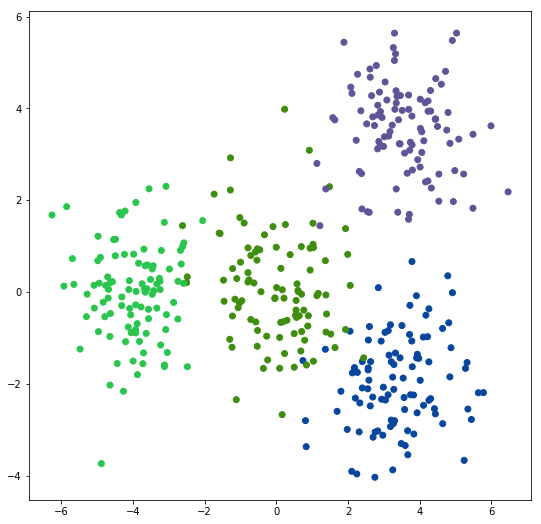

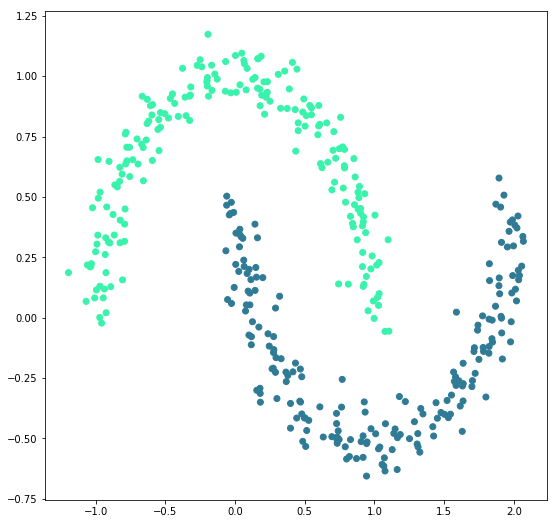

In [5]:
X_1, true_labels = make_blobs(400, 2, centers=[[0, 0], [-4, 0], [3.5, 3.5], [3.5, -2.0]])
visualize_clasters(X_1, true_labels)
X_2, true_labels = make_moons(400, noise=0.075)
visualize_clasters(X_2, true_labels)

### Задание 1 (2 балла)
Первый метод, который предлагается реализовать - метод K средних.

#### Описание методов
`fit(X, y=None)` ищет и запоминает в `self.centroids` центроиды кластеров для набора данных.
`predict(X)` для каждого элемента из `X` возвращает номер кластера, к которому относится данный элемент.

#### Инициализация кластеров
Есть несколько вариантов инициализации кластеров. Нужно реализовать их все:
1. `random` - центроиды кластеров являются случайными точками
2. `sample` - центроиды кластеров выбираются случайно из набора данных
3. `k-means++` - центроиды кластеров инициализируются при помощи метода K-means++


In [6]:
class KMeans:
    def __init__(self, n_clusters, init="random", max_iter=300):
        self.n_clusters = n_clusters
        self.init = init
        self.max_iter = max_iter
        self.X = np.array([[]])
        self.classes = np.array([])
        self.step = 0
        self.done = False

    def fit(self, X, y=None):

        if self.init == "random" and self.step == 0:
            self.step = 1
            list = []
            for i in range(self.n_clusters):
                    x = random.randint(-6, 6)
                    y = random.randint(-6, 6)
                    list.append(x)
                    list.append(y)

            self.centroids = np.array(list)
            self.centroids.shape = (self.n_clusters, 2)

        elif self.init == "sample" and self.step == 0:
            self.step = 1
            list = []
            dots = []
            for i in range(self.n_clusters):
                dot = random.randint(0, len(X))
                while dot in dots:
                    dot = random.randint(0, len(X))
                list.append(X[dot][0])
                list.append(X[dot][1])
                dots.append(dot)
            self.centroids = np.array(list)
            self.centroids.shape = (self.n_clusters, 2)

        elif self.init == "k-means++" and self.step == 0:
            self.step = 1
            dots = []
            dots.append(random.randint(0, len(X)))
            for i in range(self.n_clusters-1):
                sum = 0
                for j in range(len(X)):
                    closest = []
                    for k in range(len(dots)):
                        closest.append(math.sqrt((X[dots[k]][0] - X[j][0])**2 + (X[dots[k]][1] - X[j][1])**2))

                    closest.sort()
                    sum += closest[0]

                next_center = 0
                rnd = random.uniform(0.001,0.999)*sum
                sum = 0
                next_center = 0
                while sum <= rnd and next_center < len(X):
                    closest = []
                    for k in range(len(dots)):
                        closest.append(math.sqrt((X[dots[k]][0] - X[next_center][0])**2 + (X[dots[k]][1] - X[next_center][1])**2))

                    closest.sort()
                    sum += closest[0]
                    next_center += 1

                dots.append(next_center)

            list = []
            for i in range(len(dots)):
                list.append(X[dots[i]][0])
                list.append(X[dots[i]][1])
            self.centroids = np.array(list)
            self.centroids.shape = (self.n_clusters, 2)

        elif self.step != 0:
            list = []
            for i in range(self.n_clusters):
                sum = 0
                x = 0
                y = 0
                for j in range(len(X)):
                    if self.classes[j] == i:
                        sum += 1
                        x += X[j][0]
                        y += X[j][1]
                if sum == 0:
                    x = self.centroids[i][0]
                    y = self.centroids[i][1]
                else:
                    x /= sum
                    y /= sum

                list.append(x)
                list.append(y)

            self.centroids = np.array(list)
            self.centroids.shape = (self.n_clusters, 2)

    def predict(self, X):
        self.classes = []
        centers = spatial.KDTree(self.centroids)
        for i in range(len(X)):
            closest = centers.data[centers.query(X[i], 1)[1]]
            for j in range(len(self.centroids)):
               if closest[0] == self.centroids[j][0] and closest[1] == self.centroids[j][1]:
                   self.classes.append(j)
                   break
        prev_centroids = copy.copy(self.centroids)
        self.fit(X)

        sum = 0
        for i in range(self.n_clusters):
            sum += math.sqrt((self.centroids[i][0] - prev_centroids[i][0])**2 + (self.centroids[i][1] - prev_centroids[i][1])**2)
        if sum == 0:
            self.done = True

        while self.done != True:
            self.predict(X)


        values = {}
        count = 0
        for i in range(len(self.classes)):
            if self.classes[i] not in values:
                values[self.classes[i]] = count
                count += 1
        for i in range(len(self.classes)):
            self.classes[i] = values[self.classes[i]]

        return self.classes

Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

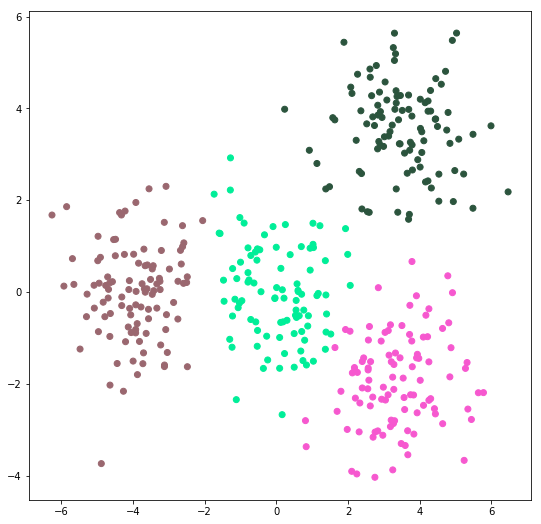

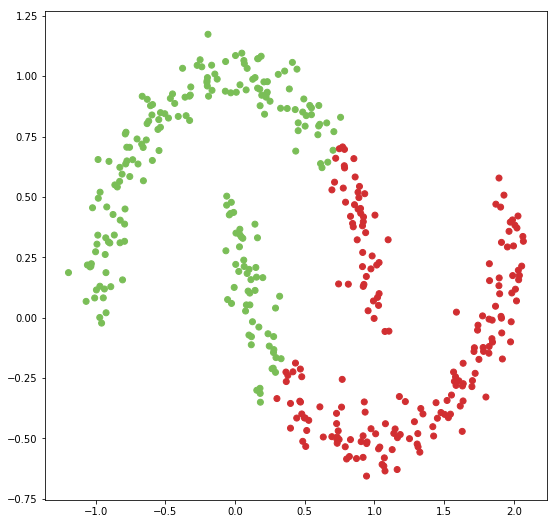

In [9]:
kmeans = KMeans(n_clusters=4, init="k-means++")
kmeans.fit(X_1)
labels = kmeans.predict(X_1)
visualize_clasters(X_1, labels)

kmeans = KMeans(n_clusters=2, init="k-means++")
kmeans.fit(X_2)
labels = kmeans.predict(X_2)
visualize_clasters(X_2, labels)

### Задание 2 (4 балла)
В отличии от K-means, DBScan не позволяет задать количество кластеров, на которое будут разбиты данные. Руководствуясь геометрической интерпретацией, он позволяет выделять кластеры более сложной формы.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Возможные метрики
* `euclidean`
* `manhattan`
* `chebyshev`

__Для быстрого поиска соседей используйте `sklearn.neighbors.KDTree`__

In [10]:
class DBScan:
    def __init__(self, eps=0.5, min_samples=5, leaf_size=40, metric="euclidean"):
        self.eps = eps
        self.min_samples = min_samples
        self.leaf_size = leaf_size
        self.metric = metric
        self.classes = np.array([])


    def fit_predict(self, X, y=None):
        tree = KDTree(X, leaf_size = self.leaf_size)
        list = []
        for i in range(len(X)):
            list.append(-1)
        self.classes = np.array(list)

        cluster = -1
        for i in range(len(X)):
            if self.classes[i] != -1:
                continue

            inds = tree.query_radius([X[i]], r = self.eps)
            if len(inds[0]) < self.min_samples:
                self.classes[i] = -2
            else:
                cluster += 1
                neighbors = []
                for j in range(len(inds[0])):
                    neighbors.append(inds[0][j])

                for j in range(len(neighbors)):
                    if self.classes[neighbors[j]] == -2:
                        self.classes[neighbors[j]] = cluster

                    if self.classes[neighbors[j]] != -1:
                        continue

                    self.classes[neighbors[j]] = cluster
                    next_neighbors = tree.query_radius([X[neighbors[j]]], r = self.eps)
                    if len(next_neighbors) >= self.min_samples:
                        neighbors.append(next_neighbors)

        values = {}
        count = 0
        for i in range(len(self.classes)):
            if self.classes[i] not in values:
                values[self.classes[i]] = count
                count += 1
        for i in range(len(self.classes)):
            self.classes[i] = values[self.classes[i]]



        return self.classes


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

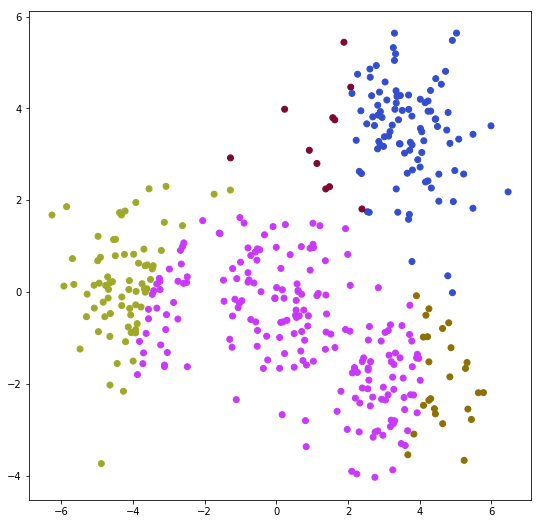

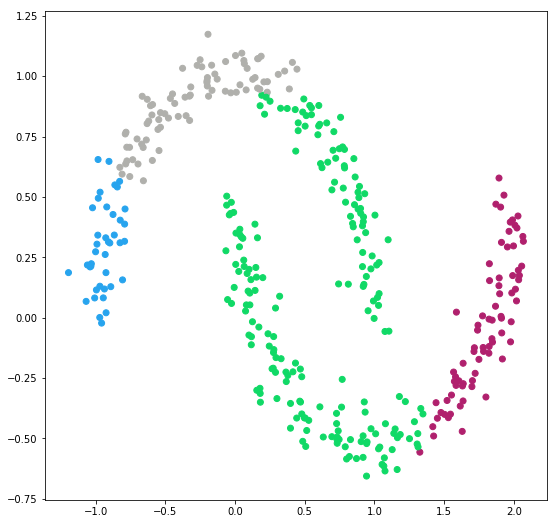

In [45]:
dbscan = DBScan(eps=4, min_samples=6, metric="chebyshev") #такие параметры давали хорошие результаты чаще других
labels = dbscan.fit_predict(X_1)
visualize_clasters(X_1, labels)

dbscan = DBScan(eps=1.1, min_samples=15, metric="euclidean") #такие параметры давали хорошие результаты чаще других
labels = dbscan.fit_predict(X_2)
visualize_clasters(X_2, labels)

### Задание 3 (4 балла)
Идея AgglomerativeClustering заключается в том, чтобы итеративно объединять кластеры с наименьшим расстоянием между ними. Данный метод обладает высокой вычислительной сложностью, поэтому применим только для относительно небольших наборов данных.

#### Описание методов
`fit_predict(X, y=None)` для каждого элемента `X` возвращает метку кластера, к которому он относится.

#### Linkage-функции
__Linkage__ - это способ, которым будет рассчитываться расстояние между кластерами. Предлагается реализовать три варианта такой функции:
1. `average` - расстояние рассчитывается как среднее расстояние между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `single` - расстояние рассчитывается как минимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.
2. `complete` - расстояние рассчитывается как максимальное из расстояний между всеми парами точек, где одна принадлежит первому кластеру, а другая - второму.

In [49]:
class AgglomertiveClustering:
    def __init__(self, n_clusters=16, linkage="average"):
        self.n_clusters = n_clusters
        self.linkage = linkage

    def fit_predict(self, X, y=None):
        clusters = [[0] * 1 for i in range(len(X))]

        for i in range(len(X)):
            clusters[i][0]=i

        while(len(clusters) != self.n_clusters):
            cluster1 = 0
            cluster2 = 0
            new_cluster = []
            sum = 9999
            min = 9999
            max = 0
            for i in range(len(clusters)):
                for j in range(len(clusters)):
                    if i == j:
                        continue
                    if self.linkage == "average":
                        dist = 0
                        for k in range(len(clusters[i])):
                            for z in range(len(clusters[j])):
                                dist += math.sqrt((X[clusters[i][k]][0] - X[clusters[j][z]][0])**2 + (X[clusters[i][k]][1] - X[clusters[j][z]][1])**2)
                        new_sum = dist/((len(clusters[i]))*len(clusters[j]))
                        if new_sum < sum:
                            sum = new_sum
                            cluster1 = i
                            cluster2 = j
                    elif self.linkage == "single":
                        for k in range(len(clusters[i])):
                            for z in range(len(clusters[j])):
                                dist = math.sqrt((X[clusters[i][k]][0] - X[clusters[j][z]][0])**2 + (X[clusters[i][k]][1] - X[clusters[j][z]][1])**2)
                                if dist < min:
                                    min = dist
                                    cluster1 = i
                                    cluster2 = j

                    elif self.linkage == "complete":
                        for k in range(len(clusters[i])):
                            for z in range(len(clusters[j])):
                                dist = math.sqrt((X[clusters[i][k]][0] - X[clusters[j][z]][0])**2 + (X[clusters[i][k]][1] - X[clusters[j][z]][1])**2)
                                if dist > max:
                                    max = dist
                                    cluster1 = i
                                    cluster2 = j

            for i in range(len(clusters[cluster1])):
                new_cluster.append(clusters[cluster1][i])

            for i in range(len(clusters[cluster2])):
                new_cluster.append(clusters[cluster2][i])
            todel1 = clusters[cluster1]
            todel2 = clusters[cluster2]

            clusters.remove(todel1)
            clusters.remove(todel2)
            clusters.append(new_cluster)

        res = [0]*len(X)
        for i in range(len(clusters)):
            for j in range(len(clusters[i])):
                res[clusters[i][j]] = i

        return res


Протестируйте алгоритм на синтетических данных. При необходимости подберите гиперпараметры для достижения лучшего качества кластеризации.

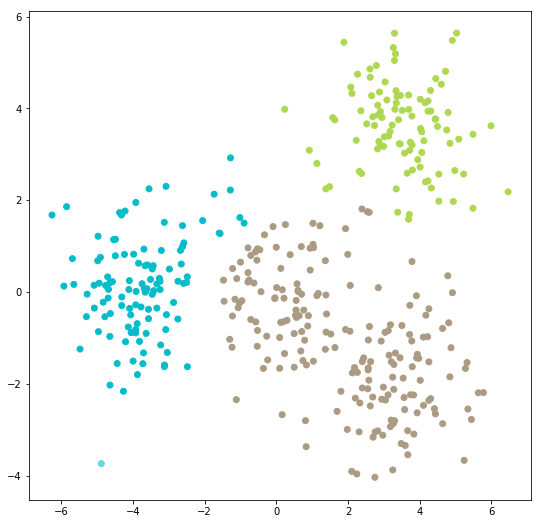

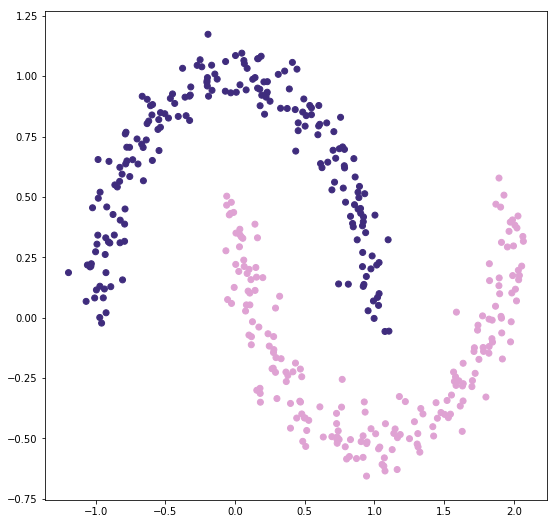

In [50]:
agg_clustering = AgglomertiveClustering(n_clusters=4, linkage="average")
labels = agg_clustering.fit_predict(X_1)
visualize_clasters(X_1, labels)

agg_clustering = AgglomertiveClustering(n_clusters=2, linkage="single")
labels = agg_clustering.fit_predict(X_2)
visualize_clasters(X_2, labels)